# Getting started

## Python libraries

In [1]:
# IMPORT LIBRARIES

# utils
import warnings                     # for suppressing warnings
warnings.filterwarnings('ignore')   

import os                           # for interfacing Python with the OS
import platform
import random                       # for generating random numbers with base Python
from   pyprojroot import here       # for using relative paths
import datetime                     # for manipulating date and time variables
from   datetime import date
import time
import csv                          # for exporting data to csv files

import numpy as np                  # for scientific computing 
import pandas as pd                 # for handling data
import seaborn as sns               # for plotting data
import matplotlib
matplotlib.use('Agg')               
from   matplotlib import pyplot as plt


# HDDM
import hddm                         # for fitting HDDM
from   patsy import dmatrix         # for building design matrices

## Reproducibility

In [2]:
# SET SEED

# set seed value
seed_value = 3112

# set PYTHONHASHSEED pseudo-random generator at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# set random pseudo-random generator at a fixed value
random.seed(seed_value) 

# set numpy pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [3]:
# OPERATING SYSTEM

print( "STANDARD \t SYSTEM \t RELEASE" )
print( "--------------------------------------------------" )
print( os.name + "\t\t " + platform.system() + "\t\t " + platform.release() )
print( "\n" )

STANDARD 	 SYSTEM 	 RELEASE
--------------------------------------------------
posix		 Linux		 5.8.0-44-generic




In [4]:
# HDDM PACKAGE USED

print( "HDDM version used: " + hddm.__version__ )
print( "\n" )

HDDM version used: 0.8.0




## Project info

In [5]:
# PROJECT'S NAME

proj_name = "hddm_wit"

In [6]:
# PROJECT'S DIRECTORIES

root_folder = here()  # project's root folder

print( "Current working directory: \n\n" + "\t" + str(root_folder) )
print( "\n" )

Current working directory: 

	/home/valerio/Downloads/sos




## Behavioural data

In [7]:
# LOAD DATA

# data filename
my_csv = "wit_hddm.csv"

# read data from csv file
data = hddm.load_csv( os.path.join(os.path.join(root_folder, "_ignore", my_csv)) )

In [8]:
# CLEAN UP DATA

# rename variables
data.rename( columns = {'response':'accuracy', 
                        'key_pressed':'response'},
             inplace = True )


# recode data
data.loc[data['heart']    == 'systole' , 'heart'   ] = 1  # systolic   trials      are   1s
data.loc[data['heart']    == 'diastole', 'heart'   ] = 0  # diastolic  trials      are   0s

data.loc[data['prime']    == 'black'   , 'prime'   ] = 1  # black      primes      are   1s
data.loc[data['prime']    == 'white'   , 'prime'   ] = 0  # white      primes      are   0s
data.loc[data['stim']     == 'gun'     , 'stim'    ] = 1  # gun        targets     are   1s
data.loc[data['stim']     == 'tool'    , 'stim'    ] = 0  # tool       targets     are   0s

data.loc[data['response'] == 'G'       , 'response'] = 1  # gun        responses   are   1s
data.loc[data['response'] == 'T'       , 'response'] = 0  # tool       responses   are   0s


# remove extra variables
data = data.drop( ['stereo_congr', 'seq_congr',
                   'trial_no'    , 'accuracy' ,
                   'conds_all'],
                    axis = 1 )


# check data
data.head(10)

,subj_idx,heart,prime,stim,response,rt
0,0,0,0,1,1,0.424
1,0,0,0,1,1,0.439
2,0,0,1,1,1,0.368
3,0,0,1,1,1,0.429
4,0,1,0,0,1,0.460
5,0,0,1,1,1,0.527
6,0,1,0,0,0,0.460
7,0,1,1,0,0,0.446
8,0,0,0,0,0,0.471
9,0,0,1,0,0,0.512


### Data coding
Data were coded according to the scheme displayed in the table.

| Coding  | Heart     | Prime  | Target | Response  |
|--------:|:----------|:-------|:-------|:----------|
|**0**    | Diastole  | White  | Tool   | TOOL key  |
|**1**    | *Systole* |*Black* | *Gun*  | *GUN key* |

# HDDM

The model is response-coded. $ \quad \Rightarrow \quad \text{Tool} = 0 \quad\quad \text{Gun} = 1$

## Preliminary steps

In [9]:
# DEFINE LINK FUNCTION FOR DECISION BIAS

def z_link_func( x, data = data ):
        stim = ( dmatrix( "0 + C(s, [[1], [-1]])",
                                     { 's': data.stim.loc[x.index] },
                                     return_type = 'dataframe' )
                     )
        
        return 1 / ( 1 + np.exp( -np.multiply(x.to_frame(), stim) ) )

In [10]:
# SET INFO FOR SAVING MODEL

# model's name
mdl_name = "HDDMRegr-three_way_interact"

# pickle's database info
db_name  = "model__" + mdl_name + ".db"
db       = 'pickle'

## Set model

### MCMC

In [11]:
# SET MCMC PARAMETERS

n_sample = 500  # number of sampling
n_burn   = 50   # number of burn-ins

print("\t MCMC info: \n")
print( "SAMPLES \t BURN-INS" )
print( "------------------------------" )
print( str(n_sample) + "\t\t " + str(n_burn) + "\n" )

	 MCMC info: 

SAMPLES 	 BURN-INS
------------------------------
500		 50



### Regressions

In [12]:
# SPECIFY REGRESSION EQUATIONS

v_reg = { 'model': 'v ~ 0 + C(heart)*C(prime)*C(stim)', 'link_func': lambda x:x  }
z_reg = { 'model': 'z ~ 0 + C(heart)*C(prime)'        , 'link_func': z_link_func }

# regressions' descriptor
regr_descr = [v_reg, z_reg]

## Retrieve parameters' estimates

In [13]:
# HDDM FITTED


# FIT MODEL
print( "Fitting HDDM...\n" )

# ### stopwatch starts
start_time = datetime.datetime.now()

print( "Model fitting started on %s at %s.\n\n" %( start_time.strftime("%d-%b-%Y"), start_time.strftime("%H:%M:%S") ) )

#=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


# HDDM
my_model = hddm.HDDMRegressor(
                               # feed data in
                               data,
                               # regressions
                               regr_descr,
                               # estimate and manage outliers
                               p_outlier = 0.05,
                               # include the following params
                               include   = ('z'),  # 's*' params allow for
                                                   #      inter-trial variability
                               # estimate effect of regressors for each subject
                               group_only_regressors = False
)

# find a good starting point for facilitating model's convergence
my_model.find_starting_values()

# MCMC sampling
my_model.sample( n_sample, burn   = n_burn,
                           dbname = db_name, 
                           db     = db )


#=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

# ### stopwatch ends
end_time = datetime.datetime.now()

print( "Model fitting ended on %s at %s.\n" %( end_time.strftime("%d-%b-%Y"), end_time.strftime("%H:%M:%S") ) )



# today's date
date_today = date.today().strftime("%Y-%m-%d")

# print how long it took to run the model
delta_time = end_time - start_time
print( "--------------------------------------------------\n\n" )
print( "HDDM finished fitting %s on %s.\n%s took %s (hh:mm:ss).\n" %( mdl_name, date_today, mdl_name, str(delta_time).split(".")[0] ) )

Fitting HDDM...

Model fitting started on 12-Apr-2021 at 13:55:05.


Adding these covariates:
['v_C(heart)[0]', 'v_C(heart)[1]', 'v_C(prime)[T.1]', 'v_C(stim)[T.1]', 'v_C(heart)[T.1]:C(prime)[T.1]', 'v_C(heart)[T.1]:C(stim)[T.1]', 'v_C(prime)[T.1]:C(stim)[T.1]', 'v_C(heart)[T.1]:C(prime)[T.1]:C(stim)[T.1]']
Adding these covariates:
['z_C(heart)[0]', 'z_C(heart)[1]', 'z_C(prime)[T.1]', 'z_C(heart)[T.1]:C(prime)[T.1]']
 [-----------------100%-----------------] 501 of 500 complete in 5118.5 secModel fitting ended on 12-Apr-2021 at 15:23:02.

--------------------------------------------------


HDDM finished fitting HDDMRegr-three_way_interact on 2021-04-12.
HDDMRegr-three_way_interact took 1:27:57 (hh:mm:ss).



# Posterior distributions

In [16]:
# MODEL DESCRIPTORS

my_model.model_descrs

[{'outcome': 'v',
  'model': ' 0 + C(heart)*C(prime)*C(stim)',
  'params': ['v_C(heart)[0]',
   'v_C(heart)[1]',
   'v_C(prime)[T.1]',
   'v_C(stim)[T.1]',
   'v_C(heart)[T.1]:C(prime)[T.1]',
   'v_C(heart)[T.1]:C(stim)[T.1]',
   'v_C(prime)[T.1]:C(stim)[T.1]',
   'v_C(heart)[T.1]:C(prime)[T.1]:C(stim)[T.1]']},
 {'outcome': 'z',
  'model': ' 0 + C(heart)*C(prime)',
  'params': ['z_C(heart)[0]',
   'z_C(heart)[1]',
   'z_C(prime)[T.1]',
   'z_C(heart)[T.1]:C(prime)[T.1]']}]

In [26]:
# GET NODES NAMES

my_model.get_group_nodes()["knode_name"]

a                                                                                              a
a_std                                                                                      a_std
t                                                                                              t
t_std                                                                                      t_std
v_C(heart)[0]                                                                      v_C(heart)[0]
v_C(heart)[0]_std                                                              v_C(heart)[0]_std
v_C(heart)[1]                                                                      v_C(heart)[1]
v_C(heart)[1]_std                                                              v_C(heart)[1]_std
v_C(prime)[T.1]                                                                  v_C(prime)[T.1]
v_C(prime)[T.1]_std                                                          v_C(prime)[T.1]_std
v_C(stim)[T.1]                

## 2-way interaction term

(0.95, 1.3)

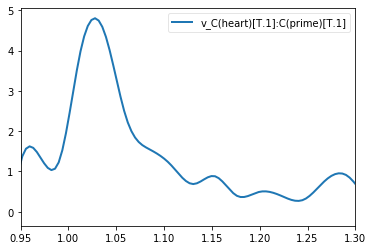

In [45]:
v_2way = my_model.nodes_db.node[["v_C(heart)[T.1]:C(prime)[T.1]"]]

hddm.analyze.plot_posterior_nodes(v_2way)
plt.xlim(0.95, 1.30)

## 3-way interaction term

(-0.5, 0)

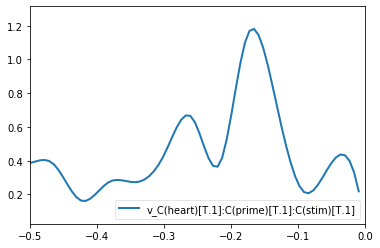

In [46]:
v_3way = my_model.nodes_db.node[["v_C(heart)[T.1]:C(prime)[T.1]:C(stim)[T.1]"]]

hddm.analyze.plot_posterior_nodes(v_3way)
plt.xlim(-0.50, 0)